<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo-/blob/main/Hot_Dog_vs_Not_Hot_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)


In [4]:
def dataset_head(dataset,n=20):
   for i, (img,lbl) in enumerate(dataset.take(n),1):
     print(f"{i}. Label: {ds_info.features['label'].int2str(lbl)},Shape:{img.shape},Dtype:{img.dtype}") #int2str(lbl) just changes the number label into the actual class name

dataset_head(ds['train'])

1. Label: chicken_quesadilla,Shape:(512, 384, 3),Dtype:<dtype: 'uint8'>
2. Label: grilled_salmon,Shape:(512, 342, 3),Dtype:<dtype: 'uint8'>
3. Label: falafel,Shape:(512, 382, 3),Dtype:<dtype: 'uint8'>
4. Label: breakfast_burrito,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
5. Label: lasagna,Shape:(384, 512, 3),Dtype:<dtype: 'uint8'>
6. Label: hot_and_sour_soup,Shape:(288, 512, 3),Dtype:<dtype: 'uint8'>
7. Label: garlic_bread,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
8. Label: huevos_rancheros,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
9. Label: hamburger,Shape:(512, 384, 3),Dtype:<dtype: 'uint8'>
10. Label: cannoli,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
11. Label: fried_rice,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
12. Label: beef_carpaccio,Shape:(512, 289, 3),Dtype:<dtype: 'uint8'>
13. Label: club_sandwich,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
14. Label: spring_rolls,Shape:(384, 512, 3),Dtype:<dtype: 'uint8'>
15. Label: pho,Shape:(512, 512, 3),Dtype:<dtype: 'uint8'>
16. Labe

In the shape tuple `(height, width, 3)`, the **3** means **3 color channels** in the image.

That usually stands for **Red, Green, and Blue (RGB)** channels — which combine to create the full color image you see.

So:

* `(489, 512, 3)` means the image is 489 pixels tall, 512 pixels wide, and has 3 color channels (RGB).
* If it was `(512, 512, 1)`, that would be a grayscale image with just 1 channel.

In short, **3 = color image with RGB channels**!


In [5]:
train_ds, valid_ds = ds["train"], ds["validation"]

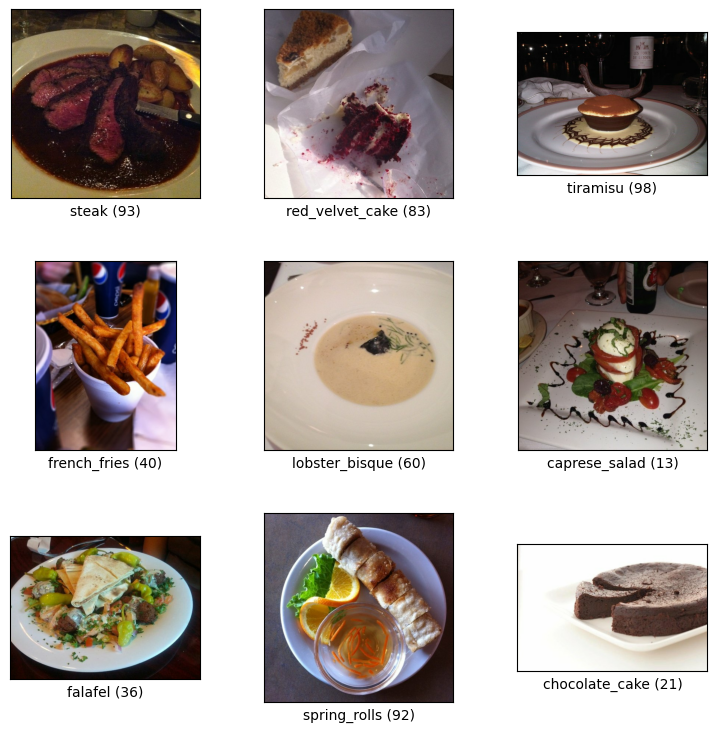

In [6]:
fig = tfds.show_examples(valid_ds,ds_info)

In [7]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55

def preprocess(image, label):
    # Resize image to 128x128 and convert pixel values to int32
    image_resized = tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN])
    image_resized = tf.cast(image_resized, tf.int32)

    # Check if label equals HOT_DOG_CLASS, convert result (True/False) to int32 (1 or 0)
    label_binary = tf.cast(label == HOT_DOG_CLASS, tf.int32)

    return image_resized, label_binary

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)


* **`MAX_SIDE_LEN = 128`**
  We want all images to be 128 pixels wide and 128 pixels tall.

* **`HOT_DOG_CLASS = 55`**
  The class number 55 means "hot dog" in the Food101 dataset.

* **The `preprocess` function:**

  * It takes an image and its label.
  * It resizes the image to 128x128 pixels so all images are the same size.
  * It changes the image data type to integer numbers.
  * It checks if the label is the hot dog class (55).
  * If yes, it changes the label to 1; if no, it changes it to 0. So now, labels are just 0 or 1 (hot dog or not hot dog).

* **`train_ds.map(preprocess)` and `valid_ds.map(preprocess)`**
  This applies the above function to every image and label in the training and validation datasets.

**In short:**
You are making a dataset where every image is resized and labeled as either "hot dog" (1) or "not hot dog" (0), ready for a simple classification task.


In [8]:
train_hd_size, valid_hd_size = 750, 250

def split_hotdogs(dataset, repeat_times=1):
    hotdogs = dataset.filter(lambda _, label: label == 1).repeat(repeat_times)
    not_hotdogs = dataset.filter(lambda _, label: label == 0)
    return hotdogs, not_hotdogs

# Apply to train and valid
train_hotdogs, train_nothotdogs = split_hotdogs(train_ds, repeat_times=3)
valid_hotdogs, valid_nothotdogs = split_hotdogs(valid_ds, repeat_times=3)

valid_hotdogs


<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

1. **`train_hd_size, valid_hd_size = 750, 250`**
   Just storing the number of samples you want for training and validation.

2. **`split_hotdogs(dataset, repeat_times=1)` function**

   * **`hotdogs = dataset.filter(lambda _, label: label == 1)`** → keeps only hot dog images (label = 1).
   * **`.repeat(repeat_times)`** → repeats those hot dogs multiple times to balance the dataset.
   * **`not_hotdogs = dataset.filter(lambda _, label: label == 0)`** → keeps only non-hot dog images.
   * Returns both datasets.

3. **Apply to train and valid**

   * For training, repeat hot dogs **3 times**.
   * For validation, also repeat hot dogs **3 times**.

4. **`valid_hotdogs`**
   When you type this, it doesn’t show the images — it just tells you it’s a filtered TensorFlow dataset that contains only hot dogs from validation.



In [9]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,train_nothotdogs],weights=[0.5,0.5],stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

#EXPLAINATION
```python
batch_size = 16
```

* We are setting the number of images to process at a time in training. Here, each batch will have 16 images.

---

```python
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
```

* This line **combines two datasets**: hotdog images and non-hotdog images.
* `weights=[0.5, 0.5]` means we want **half from hotdogs, half from non-hotdogs** in the new dataset.
* `stop_on_empty_dataset=True` stops sampling when either dataset runs out of images.

---

```python
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
```

* **`cache()`**: Keeps the dataset in memory so training is faster.
* **`batch(batch_size)`**: Groups images into batches of 16.
* **`prefetch(tf.data.AUTOTUNE)`**: Prepares the next batch while the current one is being used, so training runs smoothly.

---

```python
valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
```

* Same as the train dataset, but this is for **validation**.
* Validation is used to check how well your model is learning without updating it.



In [ ]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

# **Neural Network implementation**

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [11]:
random.seed(0)
model = models.Sequential()
#divides all pixel values by 255, converting them to a 0–1 range.Normalizes image data so the model can learn efficiently.
model.add(layers.Rescaling(1./255))
#This layer extracts important features(128 feature) from the image, like edges, corners, or textures, which the model can later use to classify images.
model.add(layers.Conv2D(128,(3, 3), activation='relu', input_shape =(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)))
#Converts the 2D feature maps into a 1D vector so it can be fed into dense layers.
model.add(layers.Flatten())
#Fully connected layer with 128 neurons, followed by dropout.
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits= True),
              metrics = ['accuracy'])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1,
   callbacks=[early_stopping]
)

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.5220 - loss: 0.2201 - val_accuracy: 0.4987 - val_loss: 0.1910
Epoch 2/50
 13/292 ━━━━━━━━━━━━━━━━━━━━ 6:18 1s/step - accuracy: 0.4953 - loss: 0.2086

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

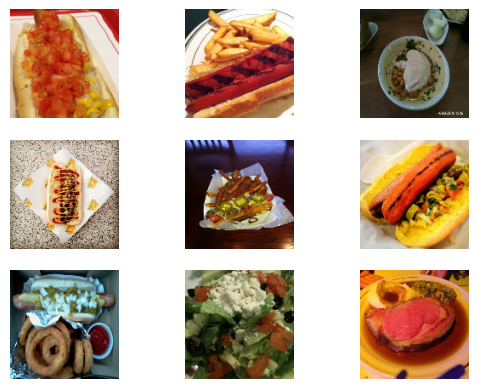

In [15]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [16]:
labels[:9]


<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>